<a href="https://www.kaggle.com/code/gpreda/item-based-collaborative-filtering-using-knn?scriptVersionId=128753675" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>


<h1>Item-based Collaborative Filtering using KNN</h1>

# Introduction

This Notebook is building a Item-based collaborative filtering Recommendation System for Movielens.

# Analysis preparation

In [1]:
import numpy as np
import pandas as pd
import re
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

## Read users data

In [2]:
user_columns = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users_df = pd.read_csv('../input/movielens-100k-dataset/ml-100k/u.user', sep='|', names=user_columns) 
users_df.head(2)

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043


## Read movies data

In [3]:
genre_df = pd.read_csv('../input/movielens-100k-dataset/ml-100k/u.genre', sep='|', encoding='latin-1')
genre_columns = ["unknown"] + list(genre_df[genre_df.columns[0]].values)
print(genre_columns)

['unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [4]:
movie_columns = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies_df = pd.read_csv('../input/movielens-100k-dataset/ml-100k/u.item', sep='|', names=movie_columns+genre_columns,
                     encoding='latin-1')

Because we are not building now a content-based recommender, we retain only `movie_id` and `title`.

In [5]:
movies_df = movies_df[["movie_id", "title"]]
movies_df.head(2)

,movie_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)


## Read ratings data

In [6]:
ratings_columns = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings_df = pd.read_csv('../input/movielens-100k-dataset/ml-100k/u.data', sep='\t', names=ratings_columns)
ratings_df.drop( "unix_timestamp", inplace = True, axis = 1 ) 
ratings_df.head(2)

,user_id,movie_id,rating
0,196,242,3
1,186,302,3


We merge now ratings with movie data.

In [7]:
rating_movies_df = ratings_df.merge(movies_df, how="outer")

In [8]:
print(rating_movies_df.shape)
rating_movies_df.head(2)

(100000, 4)


,user_id,movie_id,rating,title
0,196,242,3,Kolya (1996)
1,63,242,3,Kolya (1996)


## Calculate total rating movie


We will calculate now the total rating movie. We will only consider movies with a minimum rating factor, set conveniently so that we will not take into consideration movies that were only rated by a very small number of users.

In [9]:
movie_rating = rating_movies_df.dropna(axis = 0, subset = ["title"])
movie_rating_count = movie_rating.groupby(["title"])["rating"].count().reset_index().rename(columns = {'rating': 'total_rating_count'})
movie_rating_count.head()

,title,total_rating_count
0,'Til There Was You (1997),9
1,1-900 (1994),5
2,101 Dalmatians (1996),109
3,12 Angry Men (1957),125
4,187 (1997),41


### Merge total rating count to the movie ratings

In [10]:
rating_movies_df = rating_movies_df.merge(movie_rating_count, on="title", how="right")

In [11]:
rating_movies_df.head()

,user_id,movie_id,rating,title,total_rating_count
0,223,1300,1,'Til There Was You (1997),9
1,178,1300,3,'Til There Was You (1997),9
2,342,1300,1,'Til There Was You (1997),9
3,530,1300,2,'Til There Was You (1997),9
4,416,1300,3,'Til There Was You (1997),9


### Filter only movies with a number of ratings over a threshold

In [12]:
rating_movies_df.total_rating_count.describe()

count    100000.000000
mean        169.088380
std         122.187866
min           1.000000
25%          72.000000
50%         146.000000
75%         240.000000
max         583.000000
Name: total_rating_count, dtype: float64

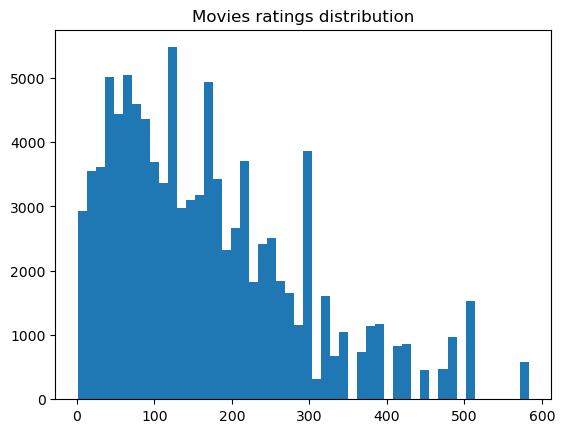

In [13]:
import matplotlib.pyplot as plt
plt.hist(rating_movies_df.total_rating_count, bins=50)
plt.title("Movies ratings distribution")
plt.show()

We will only consider moview with at least 100 ratings.

In [14]:
ratings_threshold = 100
rating_popular_movies_df = rating_movies_df.loc[rating_movies_df.total_rating_count >= ratings_threshold]
print(rating_popular_movies_df.shape)
rating_popular_movies_df.head()

(65008, 5)


,user_id,movie_id,rating,title,total_rating_count
14,5,225,2,101 Dalmatians (1996),109
15,243,225,3,101 Dalmatians (1996),109
16,200,225,4,101 Dalmatians (1996),109
17,280,225,4,101 Dalmatians (1996),109
18,1,225,2,101 Dalmatians (1996),109


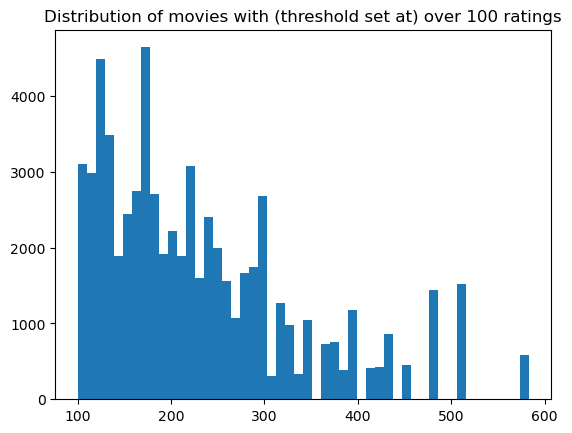

In [15]:
plt.hist(rating_popular_movies_df.total_rating_count, bins=50)
plt.title("Distribution of movies with (threshold set at) over 100 ratings")
plt.show()

## Create pivot matrix (pivot table)

In [16]:
movie_features_df = rating_popular_movies_df.pivot_table(index="title", columns="user_id", values="rating").fillna(0.0)

We create a sparse matrix from the original dataframe.
This will allow the following operations to be performed on a sparse matrix, i.e. faster (only non-zero values are included).

In [17]:
movie_features_matrix = csr_matrix(movie_features_df)

In [18]:
model_knn = NearestNeighbors(metric = "cosine", algorithm = "brute", n_neighbors = 20, n_jobs=-1)
model_knn.fit(movie_features_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [19]:
movie_features_df.shape

(338, 943)

## Test the recommendation

Select one movie.

In [20]:
query_index = np.random.choice(movie_features_df.shape[0])
print(query_index)

88


Use the model fit to get the closest movies

In [21]:
distances, indices = model_knn.kneighbors(movie_features_df.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)

In [22]:
for index in range(0, len(distances.flatten())):
    if index == 0: # the movie chosen
        print(f"Recommendation for {movie_features_df.index[query_index]} (dist: {distances.flatten()[index]})")
        print("---------------------------------------------------------")
    else:
        print(f"{index}: {movie_features_df.index[indices.flatten()[index]]} (dist: {distances.flatten()[index]})")

Recommendation for Die Hard 2 (1990) (dist: 0.0)
---------------------------------------------------------
1: Die Hard: With a Vengeance (1995) (dist: 0.20173041538392633)
2: Under Siege (1992) (dist: 0.30013513858956165)
3: True Lies (1994) (dist: 0.30220699695008446)
4: Clear and Present Danger (1994) (dist: 0.32569062006100447)
5: Batman (1989) (dist: 0.33024592599604097)


Let's pack this in a recommendation function.

In [23]:
def recommend(query_index=10, top_n=5):
    
    distances, indices = model_knn.kneighbors(movie_features_df.iloc[query_index,:].values.reshape(1, -1), n_neighbors = top_n+1)
    for index in range(0, len(distances.flatten())):
        if index == 0: # the movie chosen
            print(f"Recommendation for {movie_features_df.index[query_index]} (dist: {distances.flatten()[index]})")
            print("---------------------------------------------------------")
        else:
            print(f"{index}: {movie_features_df.index[indices.flatten()[index]]} (dist: {distances.flatten()[index]})")

In [24]:
recommend(10,10)

Recommendation for Alien (1979) (dist: 2.6645352591003757e-15)
---------------------------------------------------------
1: Aliens (1986) (dist: 0.19127812393550103)
2: Terminator, The (1984) (dist: 0.27865435344061085)
3: Raiders of the Lost Ark (1981) (dist: 0.28887374692649737)
4: Blade Runner (1982) (dist: 0.28970798320633884)
5: Terminator 2: Judgment Day (1991) (dist: 0.30133658931838925)
6: Empire Strikes Back, The (1980) (dist: 0.3069814150907276)
7: Silence of the Lambs, The (1991) (dist: 0.31148983683897913)
8: Fugitive, The (1993) (dist: 0.3284787630001317)
9: Jaws (1975) (dist: 0.33243187465237467)
10: Star Trek: The Wrath of Khan (1982) (dist: 0.3342703307915712)


In [25]:
recommend(42,10)

Recommendation for Bonnie and Clyde (1967) (dist: 0.0)
---------------------------------------------------------
1: Chinatown (1974) (dist: 0.42066501570107273)
2: Psycho (1960) (dist: 0.46519832659902893)
3: Taxi Driver (1976) (dist: 0.47603189095978127)
4: Citizen Kane (1941) (dist: 0.47616138852574974)
5: Graduate, The (1967) (dist: 0.48699573443048705)
6: Butch Cassidy and the Sundance Kid (1969) (dist: 0.4930022702618334)
7: Jaws (1975) (dist: 0.4953894237158909)
8: One Flew Over the Cuckoo's Nest (1975) (dist: 0.5021222158305975)
9: Gone with the Wind (1939) (dist: 0.5088263005371157)
10: Some Like It Hot (1959) (dist: 0.5096070071209811)


In [26]:
recommend(314,10)

Recommendation for Trainspotting (1996) (dist: 0.0)
---------------------------------------------------------
1: Fargo (1996) (dist: 0.41082672987541125)
2: Twelve Monkeys (1995) (dist: 0.4510832529212845)
3: People vs. Larry Flynt, The (1996) (dist: 0.46627884034343214)
4: Leaving Las Vegas (1995) (dist: 0.477768858854301)
5: Swingers (1996) (dist: 0.5013133139677624)
6: Welcome to the Dollhouse (1995) (dist: 0.5082739901363638)
7: Heat (1995) (dist: 0.5122713131697229)
8: Chasing Amy (1997) (dist: 0.5132437066212079)
9: Pulp Fiction (1994) (dist: 0.5159732847601468)
10: Godfather, The (1972) (dist: 0.5172032358726513)
